In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data/assessment_data.tsv', sep='\t', parse_dates=True)
df['listing_date'] = pd.to_datetime(df.listing_date)
df['event_datetime'] = pd.to_datetime(df.event_datetime)
df.head()

,event_id,listing_date,event_listing_date_id,taxonomy,event_title,event_datetime,tickets_listed,mean_listing_price,performer_1,performer_2,performer_3,performer_4,venue_name
0,3594116,2017-06-01,3594116_17318,MLB Baseball,Arizona Diamondbacks at Los Angeles Dodgers,2017-07-06 19:10:00,13102.0,48.0,Los Angeles Dodgers,Arizona Diamondbacks,NaN,NaN,Dodger Stadium
1,3594065,2017-06-01,3594065_17318,MLB Baseball,Arizona Diamondbacks at Los Angeles Dodgers,2017-09-06 19:10:00,8942.0,56.0,Los Angeles Dodgers,Arizona Diamondbacks,NaN,NaN,Dodger Stadium
2,3594070,2017-06-01,3594070_17318,MLB Baseball,Arizona Diamondbacks at Los Angeles Dodgers,2017-09-04 17:10:00,10344.0,49.0,Los Angeles Dodgers,Arizona Diamondbacks,NaN,NaN,Dodger Stadium
3,3594118,2017-06-01,3594118_17318,MLB Baseball,Arizona Diamondbacks at Los Angeles Dodgers,2017-07-05 19:10:00,13130.0,32.0,Los Angeles Dodgers,Arizona Diamondbacks,NaN,NaN,Dodger Stadium
4,3594068,2017-06-01,3594068_17318,MLB Baseball,Arizona Diamondbacks at Los Angeles Dodgers,2017-09-05 19:10:00,11642.0,32.0,Los Angeles Dodgers,Arizona Diamondbacks,NaN,NaN,Dodger Stadium


In [105]:
len(df)

8980

In [3]:
df.dtypes

event_id                          int64
listing_date             datetime64[ns]
event_listing_date_id            object
taxonomy                         object
event_title                      object
event_datetime           datetime64[ns]
tickets_listed                  float64
mean_listing_price              float64
performer_1                      object
performer_2                      object
performer_3                      object
performer_4                      object
venue_name                       object
dtype: object

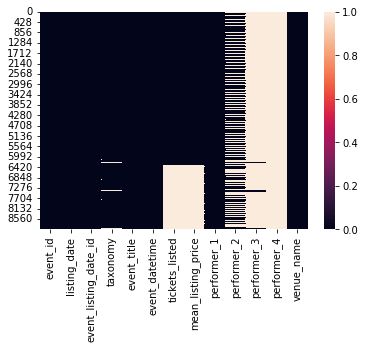

In [4]:
sns.heatmap(df.isna())

# Data Analysis

Understand features more to understand how to build the model

- Understand central tendency and distribution of features
- Understand correlation between features and target variables

In [5]:
df.columns

Index(['event_id', 'listing_date', 'event_listing_date_id', 'taxonomy',
       'event_title', 'event_datetime', 'tickets_listed', 'mean_listing_price',
       'performer_1', 'performer_2', 'performer_3', 'performer_4',
       'venue_name'],
      dtype='object')

# Tickets Listed vs. Mean Listing Price

I want to know the relationship between the two target variables, and see how they're related

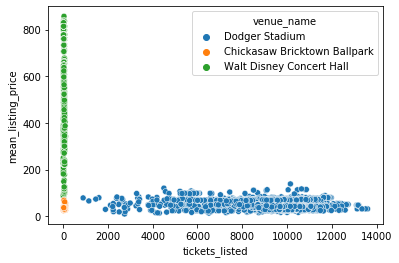

In [67]:
df_analysis = df.copy()
target_variables = ['tickets_listed', 'mean_listing_price']

sns.scatterplot(
    x='tickets_listed',
    y='mean_listing_price',
    hue='venue_name',
    data=df_analysis
)

## Taxonomy

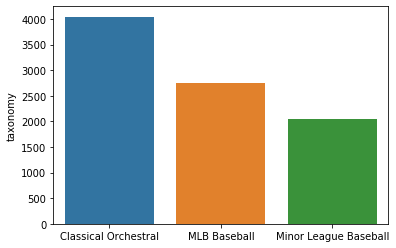

In [7]:
sns.barplot(
    x=df_analysis.taxonomy.value_counts().index,
    y=df_analysis.taxonomy.value_counts()
)

In [68]:
df_analysis.groupby('taxonomy')[['tickets_listed', 'mean_listing_price']].mean()

,tickets_listed,mean_listing_price
taxonomy,,
Classical Orchestral,41.423560,543.278657
MLB Baseball,9240.490428,51.392707
Minor League Baseball,44.144700,35.337706


There is definitely an interaction between taxonomy and the target variables, so we'll end up using these. There are a few `null` values for taxonomy, but we can easily fill them in based on the event title or venue name. Note that we'll have to do this both for `df_model` and `df_holdout`. Afterwards, we can apply one-hot encoding to `taxonomy`.

## Listing Date + Event Datetime

I want to extract the following from the listing date / event date data:

- Year / Month of the event date
- Difference in time between the listing date and the event date (in days)

In [69]:
df_analysis['event_year'] = df_analysis.event_datetime.dt.year
df_analysis['event_month'] = df_analysis.event_datetime.dt.month

In [71]:
df_analysis.event_year.value_counts()

2017    8713
2018     267
Name: event_year, dtype: int64

In [73]:
df_analysis.groupby('venue_name').event_month.value_counts()

venue_name                    event_month
Chickasaw Bricktown Ballpark  8              1024
                              7               842
                              6               188
Dodger Stadium                9              1157
                              7               732
                              8               609
                              6               244
Walt Disney Concert Hall      10             1710
                              11             1039
                              12              878
                              6               290
                              9               267
Name: event_month, dtype: int64

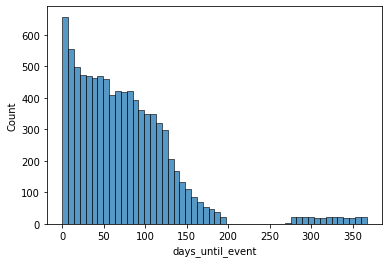

In [9]:
df_analysis['days_until_event'] = (df_analysis.event_datetime - df_analysis.listing_date).dt.days
sns.histplot(df_analysis.days_until_event)

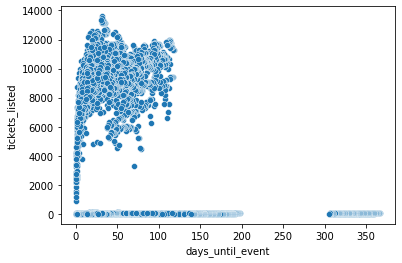

In [10]:
sns.scatterplot(
    x=df_analysis.days_until_event,
    y=df_analysis.tickets_listed
)

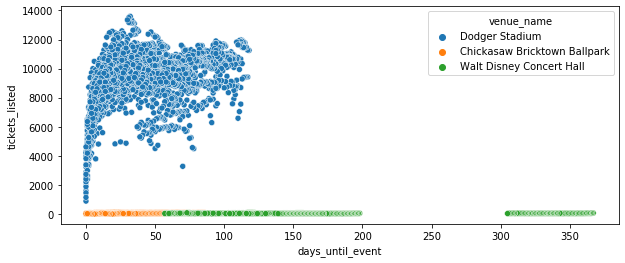

In [11]:
plt.figure(figsize=(10, 4))
sns.scatterplot(
    x=df_analysis.days_until_event,
    y=df_analysis.tickets_listed,
    hue=df_analysis.venue_name
)


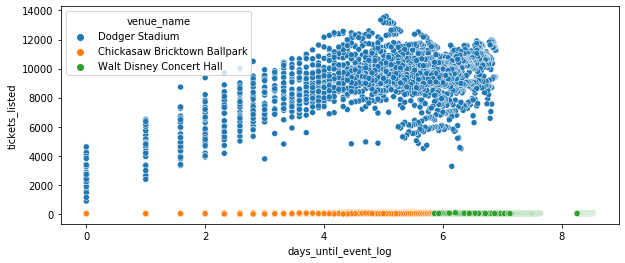

In [12]:
df_analysis['days_until_event_log'] = np.log2(df_analysis.days_until_event+1)

plt.figure(figsize=(10, 4))
sns.scatterplot(
    x=df_analysis.days_until_event_log,
    y=df_analysis.tickets_listed,
    hue=df_analysis.venue_name
)


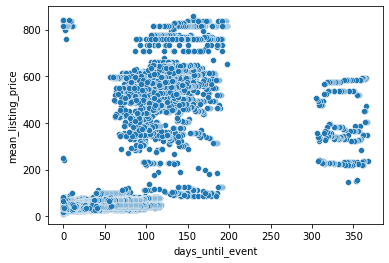

In [13]:
sns.scatterplot(
    x=df_analysis.days_until_event,
    y=df_analysis.mean_listing_price
)

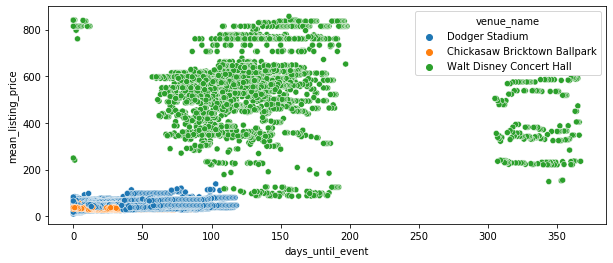

In [14]:
plt.figure(figsize=(10, 4))
sns.scatterplot(
    x=df_analysis.days_until_event,
    y=df_analysis.mean_listing_price,
    hue=df_analysis.venue_name
)

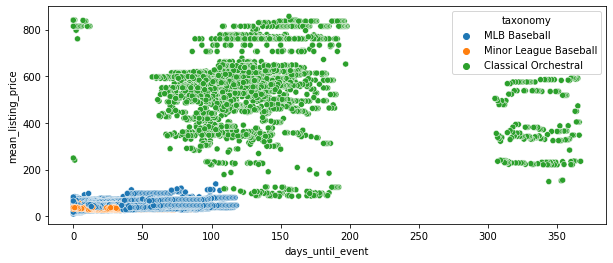

In [15]:
plt.figure(figsize=(10, 4))
sns.scatterplot(
    x=df_analysis.days_until_event,
    y=df_analysis.mean_listing_price,
    hue=df_analysis.taxonomy
)

It looks like the number of days between the listing date and the event datetime has somewhat of a correlation with tickets listed, but not with mean listing price. The correlation doesn't look to be that strong either, and I might have to transform it into an exponential function. We can either normalize the day difference, or simple split them into two groups: < 250 day difference and 250+ day difference.

Looking at the scatterplot based on taxonomy vs. venue name, it accounts for that "split." Given this, there's no need to split the two groups of distribution in two.

## Performers

There are multiple columns for performers, and there are too many unique values if we consider all of them. I can think of a few ways to summarize these pieces of information:

- Only include the # of performers
- Separate groups into top 3 most common of their respective taxonomies (i.e. `has_performer_in_top3_within_taxonomy`)
- Separate groups into top 3 highest listing of their respective taxonomies
- Separate groups into top 3 highest mean listing price of their respective taxonomies

In [20]:
performer_columns = ['performer_1', 'performer_2', 'performer_3', 'performer_4']
df_analysis['num_performers'] = df_analysis[performer_columns].notna().sum(axis=1)

In [21]:
df_analysis.groupby('num_performers')[target_variables].mean()

,tickets_listed,mean_listing_price
num_performers,,
1,41.863834,544.853660
2,4859.897301,68.885765
3,217.060606,423.767424
4,34.000000,702.700000


In [23]:
df_analysis.loc[df_analysis.taxonomy == 'Classical Orchestral'].groupby('num_performers')[target_variables].agg(['mean', 'count'])

tickets_listed       mean_listing_price      
                         mean count               mean count
num_performers                                              
1                   41.863834  2071         544.853660  2071
2                   38.748815   211         534.142038   211
3                   25.352941    17         371.030588    17
4                   34.000000    10         702.700000    10

In [24]:
# Who is the top 3 highest ticket listed performer in each category?
cols = ['event_id', 'venue_name', 'performer_1', 'performer_2', 'performer_3', 'performer_4', 'num_performers', 'tickets_listed', 'mean_listing_price']
df_melt = df_analysis[cols].melt(id_vars=['event_id', 'num_performers', 'tickets_listed', 'mean_listing_price', 'venue_name'], var_name='performer_number', value_name='performers')
df_melt2 = df_melt.groupby(['venue_name', 'performers']).agg({'num_performers': 'mean', 'tickets_listed': 'mean', 'mean_listing_price': 'mean'}).reset_index()

,venue_name,performers,num_performers,tickets_listed,mean_listing_price
35,Walt Disney Concert Hall,Marc Lowenstein,2.000000,28.692308,820.282308
41,Walt Disney Concert Hall,Yuja Wang,4.000000,34.000000,702.700000
31,Walt Disney Concert Hall,John Pizzarelli,4.000000,34.000000,702.700000
29,Walt Disney Concert Hall,Hilary Hahn,2.013245,38.596774,581.760968
33,Walt Disney Concert Hall,Los Angeles Philharmonic,1.258843,41.327959,541.387166
28,Walt Disney Concert Hall,Gustavo Dudamel,2.232033,43.595890,520.045685
37,Walt Disney Concert Hall,Natalia LaFourcade,3.000000,39.529412,507.685294
38,Walt Disney Concert Hall,Rhiannon Giddens,3.000000,37.000000,431.153529
34,Walt Disney Concert Hall,M. Ward,3.000000,37.000000,431.153529
25,Walt Disney Concert Hall,Cafe Tacuba,3.000000,33.000000,404.205000


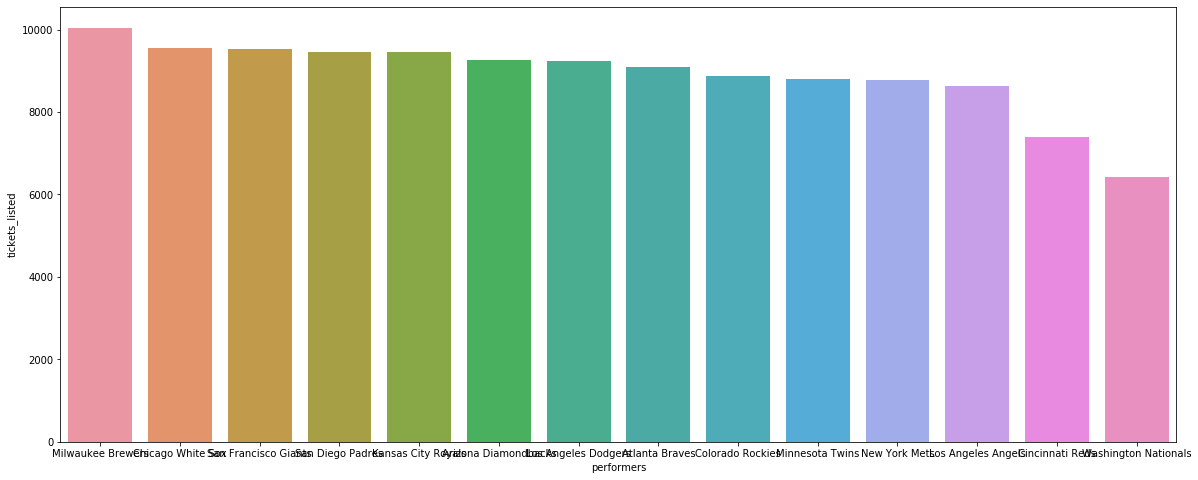

In [106]:
plt.figure(figsize=(20, 8))
sns.barplot(
    x='performers',
    y='tickets_listed',
    data=df_melt2.loc[df_melt2.venue_name=='Dodger Stadium'].sort_values('tickets_listed', ascending=False)
    # data=df_melt2.loc[df_melt2.venue_name=='Walt Disney Concert Hall'].sort_values('tickets_listed', ascending=False)
    # data=df_melt2.loc[df_melt2.venue_name=='Chickasaw Bricktown Ballpark'].sort_values('tickets_listed', ascending=False)
)

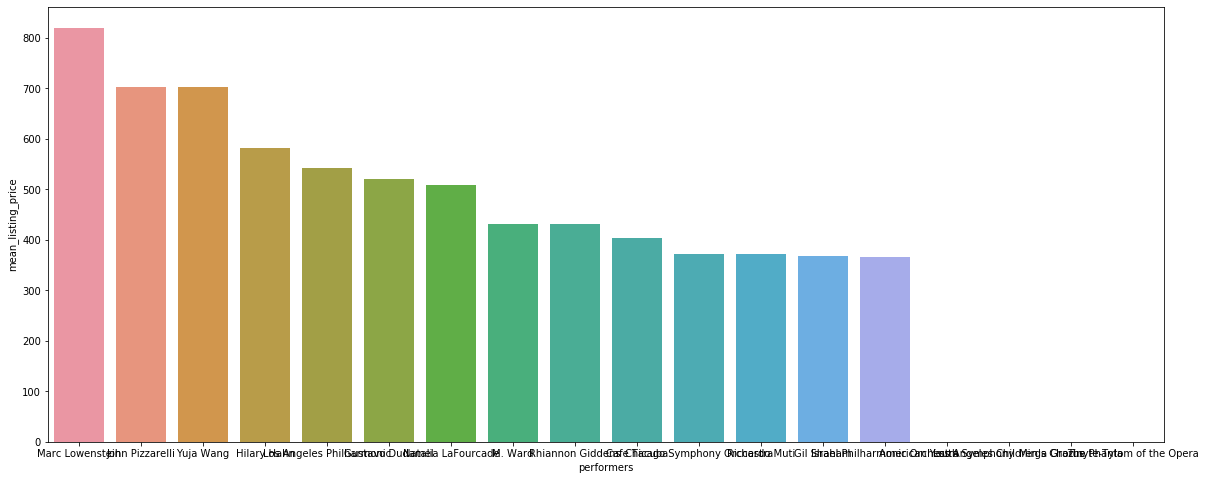

In [109]:
plt.figure(figsize=(20, 8))
sns.barplot(
    x='performers',
    y='mean_listing_price',
    # data=df_melt2.loc[df_melt2.venue_name=='Dodger Stadium'].sort_values('mean_listing_price', ascending=False)
    data=df_melt2.loc[df_melt2.venue_name=='Walt Disney Concert Hall'].sort_values('mean_listing_price', ascending=False)
    # data=df_melt2.loc[df_melt2.venue_name=='Chickasaw Bricktown Ballpark'].sort_values('mean_listing_price', ascending=False)
)

I'll be grouping the performers into three categories based on ticket listings: `ticket_listing_high`, `ticket_listing_med`, `ticket_listing_low`. I will also be grouping the perfomers based on listing price: `mean_listing_price_high`, `mean_listing_price_med`, `mean_listing_price_low`.

In [113]:
df_melt2.loc[df_melt2.venue_name=='Dodger Stadium'].sort_values('tickets_listed', ascending=False)

,venue_name,performers,num_performers,tickets_listed,mean_listing_price
18,Dodger Stadium,Milwaukee Brewers,2.000000,10046.936782,47.361667
12,Dodger Stadium,Chicago White Sox,2.000000,9563.120690,44.822759
22,Dodger Stadium,San Francisco Giants,2.000000,9533.415205,69.729327
21,Dodger Stadium,San Diego Padres,2.000000,9467.655172,51.700086
15,Dodger Stadium,Kansas City Royals,2.000000,9461.342593,49.774722
10,Dodger Stadium,Arizona Diamondbacks,2.000000,9263.717949,47.586190
17,Dodger Stadium,Los Angeles Dodgers,2.000365,9240.490428,51.392707
11,Dodger Stadium,Atlanta Braves,2.000000,9082.550505,39.770808
14,Dodger Stadium,Colorado Rockies,2.002353,8875.408638,52.279468
19,Dodger Stadium,Minnesota Twins,2.000000,8804.540881,47.642956


In [ ]:
performers_tl_high = [
    'Milwaukee Brewers'
]

performers_tl_med = [
    'Chicago White Sox',
    'San Francisco Giants',
    
]

## Venue Name

There are only three venues:

- Walt Disney Concert Hall
- Dodger's Stadium
- Chickasaw Bricktown Ballpark

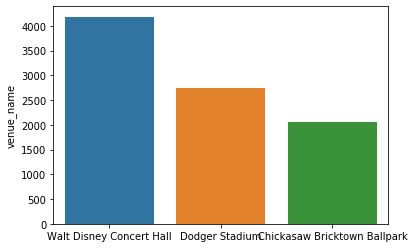

In [25]:
sns.barplot(
    x=df_analysis.venue_name.value_counts().index,
    y=df_analysis.venue_name.value_counts()
)

In [26]:
df_analysis.groupby(['taxonomy', 'venue_name']).event_id.count()

taxonomy               venue_name                  
Classical Orchestral   Walt Disney Concert Hall        4043
MLB Baseball           Dodger Stadium                  2742
Minor League Baseball  Chickasaw Bricktown Ballpark    2054
Name: event_id, dtype: int64

It looks like the venue and event taxonomy are 1:1, so we can just use one or the other. This simplifies our model and avoids collinearity. However, in real practice, this may not be the case in future, unseen data and we can't simply make this assumption.

# Data Cleaning + Feature Engineering

- Impute `null` values
- Identify and handle severe outliers
- Normalize ratio / interval values
- Feature engineer nominal / ordinal values
- Drop unusable features

In [75]:

def clean_data(data):
    data_cleaned = data.copy()

    # Calculate month
    data_cleaned['event_month'] = data_cleaned.event_datetime.dt.month
    
    # Calculate "days_until_event" field
    data_cleaned['days_until_event'] = (data_cleaned.event_datetime - data_cleaned.listing_date).dt.days

    # Transform "days_until_event" field by a logarithmic function
    data_cleaned['days_until_event_log'] = np.log2(data_cleaned.days_until_event+1)
    
    # Calculate number of performers
    performer_columns = ['performer_1', 'performer_2', 'performer_3', 'performer_4']
    data_cleaned['num_performers'] = data_cleaned[performer_columns].notna().sum(axis=1)

    # Create one-hot encoding for venue name
    onehot_venue = pd.get_dummies(data_cleaned.venue_name, prefix='venue_').iloc[:, 1:]
    data_cleaned = pd.concat([data_cleaned, onehot_venue], axis=1)

    # Drop unused fields
    unused_cols = [
        'event_id',
        'listing_date',
        'event_listing_date_id',
        'taxonomy',
        'event_title',
        'event_datetime',
        'venue_name'
    ] + performer_columns

    data_cleaned.drop(unused_cols, axis=1, inplace=True)
    return data_cleaned

df_cleaned = clean_data(df)
df_cleaned.head()

,tickets_listed,mean_listing_price,event_month,days_until_event,days_until_event_log,num_performers,venue__Dodger Stadium,venue__Walt Disney Concert Hall
0,13102.0,48.0,7,35,5.169925,2,1,0
1,8942.0,56.0,9,97,6.614710,2,1,0
2,10344.0,49.0,9,95,6.584963,2,1,0
3,13130.0,32.0,7,34,5.129283,2,1,0
4,11642.0,32.0,9,96,6.599913,2,1,0


# Splitting Data

Upcoming events from 5/20/17 through 8/31/17 are set as null for `tickets_listed` and `mean_listing_price`, so I want to separate this data first as the holdout dataset.

- `df_model`: Dataset that will be used for train/test split
    - `df_train`: Dataset that will be used for training
    - `df_test`: Dataset that will be used for testing
- `df_holdout`: Dataset that will be used as holdout dataset

**Note**: Later, I'll be using k-folds validation, so I'll be using the entirety of `df_model` to train, test, and compare different models instead of using `df_train` and `df_test`.

In [76]:
df_model = df_cleaned[df.listing_date < '2017-08-01']
df_holdout = df_cleaned[df.listing_date >= '2017-08-01']

In [77]:
X_model = df_model.iloc[:, 2:]
y_model = df_model.iloc[:, :2]

X_holdout = df_holdout.iloc[:, 2:]
y_holdout = df_holdout.iloc[:, :2]

In [78]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model)

# Model Selection

Given that most of the predictors have a Bernoulli distribution, a Decision Tree regressor will most likely perform the best. However, let's see how other common models perform as well.

In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RepeatedKFold, GridSearchCV

In [80]:
# Initial base pass
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegression': DecisionTreeRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    # 'SVR': SVR()
}

for model_name, model in models.items():
    model.fit(X_train, y_train)

    print(model_name.ljust(40, '-'))

    # Train
    y_train_pred = model.predict(X_train)
    print('RMSE (Train):')
    print(np.sqrt(((y_train - y_train_pred)**2).mean()))

    # Test
    y_test_pred = model.predict(X_test)
    print('RMSE (Test):')
    print(np.sqrt(((y_test - y_test_pred)**2).mean()))

    print('-'*50)

svr_mor = MultiOutputRegressor(SVR())
svr_mor.fit(X_train, y_train)

print(model_name.ljust(40, '-'))

# Train
print('SVR (MOR) RMSE (Train):')
svr_y_train_pred = svr_mor.predict(X_train)
print(np.sqrt(((y_train - svr_y_train_pred)**2).mean()))

# Test
print('SVR (MOR) RMSE (Test):')
svr_y_test_pred = svr_mor.predict(X_test)
print(np.sqrt(((y_test - svr_y_test_pred)**2).mean()))

LinearRegression------------------------
RMSE (Train):
tickets_listed        950.102502
mean_listing_price     95.016630
dtype: float64
RMSE (Test):
tickets_listed        954.060588
mean_listing_price     95.821497
dtype: float64
--------------------------------------------------
DecisionTreeRegression------------------
RMSE (Train):
tickets_listed        669.038155
mean_listing_price     80.260088
dtype: float64
RMSE (Test):
tickets_listed        736.666076
mean_listing_price    109.496575
dtype: float64
--------------------------------------------------
KNeighborsRegressor---------------------
RMSE (Train):
tickets_listed        884.038734
mean_listing_price     92.425645
dtype: float64
RMSE (Test):
tickets_listed        1043.438092
mean_listing_price     109.876124
dtype: float64
--------------------------------------------------
KNeighborsRegressor---------------------
SVR (MOR) RMSE (Train):
tickets_listed        5503.414450
mean_listing_price     157.789266
dtype: float64
SVR (MO

As hypothesized, the Decision Tree regressor looks to be performing the best. Let's try tuning the hyperparameters and use K-Folds Cross Validation for a more accurate estimation of the true error.

In [81]:
model_dt = DecisionTreeRegressor()

In [82]:
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
}

grid_search = GridSearchCV(
    estimator=model_dt,
    param_grid=params,
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=6814383)
)

grid_search.fit(X_train, y_train)

c:\Users\Ariel\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'squared_error'

  FitFailedWarning)
c:\Users\Ariel\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'squared_error'

  FitFailedWarning)
c:\Users\Ariel\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'squared_error'

  FitFailedWarning)
c:\Users\Ariel\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. D

GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=5, random_state=6814383),
             error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['squared_error', 'friedman_mse',
           

In [83]:
grid_search.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=20, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [84]:
gs_results = pd.DataFrame(grid_search.cv_results_)

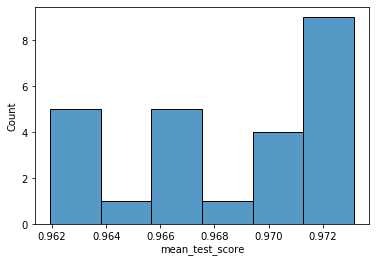

In [85]:
sns.histplot(gs_results.mean_test_score)

In [86]:
gs_predict = grid_search.predict(X_test)

# Train
print('RMSE (Train):')
gs_train_pred = grid_search.predict(X_train)
print(np.sqrt(((y_train - gs_train_pred)**2).mean()))

# Test
print('RMSE (Test):')
gs_test_pred = grid_search.predict(X_test)
print(np.sqrt(((y_test - gs_test_pred)**2).mean()))

RMSE (Train):
tickets_listed        690.949768
mean_listing_price     87.358356
dtype: float64
RMSE (Test):
tickets_listed        706.084020
mean_listing_price     90.692727
dtype: float64


# Analyzing Results

Fine tuning the Decision Tree model to this degree yielded some increase in the testing error, specifically in the mean listing price. The tickets listed RMSE is quite high, so let's look at which points have the highest error.

In [87]:
y_model_pred = grid_search.predict(X_model)

squared_error = pd.DataFrame((y_model - y_model_pred)**2)
df_model_analysis = df_analysis.loc[df.listing_date < '2017-08-01'].copy()
df_model_analysis['tickets_listed_se'] = squared_error['tickets_listed']
df_model_analysis['mean_listing_price_se'] = squared_error['mean_listing_price']

In [88]:
df_model_analysis.columns

Index(['event_id', 'listing_date', 'event_listing_date_id', 'taxonomy',
       'event_title', 'event_datetime', 'tickets_listed', 'mean_listing_price',
       'performer_1', 'performer_2', 'performer_3', 'performer_4',
       'venue_name', 'event_year', 'event_month', 'tickets_listed_se',
       'mean_listing_price_se'],
      dtype='object')

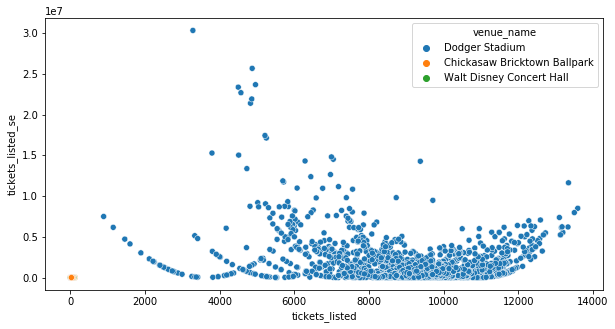

In [89]:
plt.figure(figsize=(10, 5))

sns.scatterplot(
    x='tickets_listed',
    y='tickets_listed_se',
    hue='venue_name',
    data=df_model_analysis
)

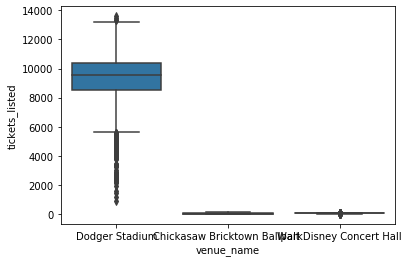

In [60]:
sns.boxplot(
    x='venue_name',
    y='tickets_listed',
    data=df_model_analysis
)

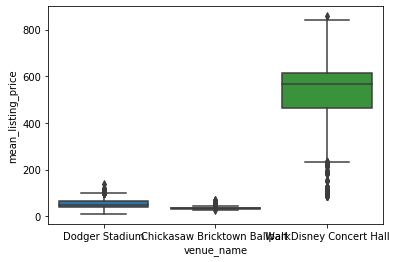

In [61]:
sns.boxplot(
    x='venue_name',
    y='mean_listing_price',
    data=df_model_analysis
)

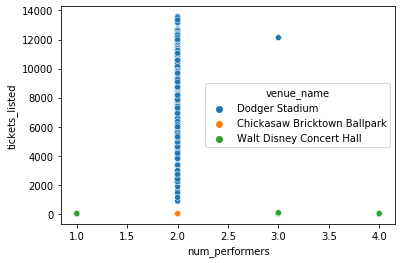

In [63]:
sns.scatterplot(
    x='num_performers',
    y='tickets_listed',
    hue='venue_name',
    data=df_model_analysis
)

In [51]:
df_model_analysis.sort_values('tickets_listed_se', ascending=False).head(100).index

Int64Index([3312, 3307, 3398, 2549, 5112, 3367, 2670, 5123, 3311, 5499, 3321,
            2892, 6159, 2779, 6252, 5603, 6064, 6151, 1067, 5875, 5784, 5695,
            6244, 5967,  283, 5320, 3105,  817, 3000,  549, 4335,  421, 5415,
            3320, 3938, 5510, 5023, 3210, 4823, 4923,  555,  145, 4432, 3630,
            3735, 4723, 4623, 5222,  931, 4529, 3836, 4039, 4238, 5307,  142,
            5778, 2657,  553, 4140,  419,  284,    3, 5871, 5686, 6056,    0,
            5595,  948, 5404, 5959,  286,  682, 5209,  956, 4420, 5200,  558,
             415,  969,  804, 5174, 1068,  308, 5119,    8, 5010, 4517,  836,
            5204, 3525,  171,  445, 2725,  138, 4911, 4813,  579, 3420, 4616,
             495],
           dtype='int64')

# Final Thoughts

Given more time, I would have liked to do the following:

- I would have done more feature engineering
    - One-hot encoded performers
- I would have analyzed the data within the performers more
    - Boxplot graphs of tickets listed and mean ticket price per performer to find outliers
- Include external data (e.g. social media data, google trends data, etc.)
- I would have built a better data cleaning pipeline with tests e.g.:
    - Checks for outliers
    - Checks for `null` values at the end of data cleaning process
    - Checks for correct one-hot encoding columns (i.e. see if new data has new value)
- I would have built a more readable way of monitoring testing e.g.:
    - How long training and testing take
    - Relevant statistics on each model monitored over training iterations
    - Showing bias-variance trade-off
- I would have separated the holdout data from the rest before the analysis to reflect real-world circumstances
- Applied and assessed other models